In [495]:
import xml.etree.ElementTree as ET
import os, sys
#import nltk
#from nltk.corpus import names
#nltk.download('punkt')
#nltk.download('names')
import string
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
%matplotlib inline

In [496]:
# import data
df = pd.read_excel('Card Samples/group ids not identified.xlsx', index_col=None, header=0, dtype={'word': str})

# fill NAs
df1 = df.fillna(0)

# remove include=0
df1 = df1.loc[df1.include==1]

Split the lines into individual words.

In [497]:
df1_values = df1.values.copy()
new_values = np.empty((1,12))

# split rows to individual words
for i in range(df1_values[:,1].shape[0]):
    for word in df1_values[i,1].split():
        new_row = df1_values[i,:].copy()
        new_row[1] = word
        new_row = new_row.reshape(1,-1)
        new_values = np.append(new_values, new_row, axis=0)

# delete first row
new_values = new_values[1:,:]

# create dataframe
df2 = pd.DataFrame(columns=df1.columns.tolist(), data=new_values)

# horizontal location
df2 = df2.assign(x_loc=0.5*df2.middle + df2.right_side)
df2.x_loc = df2.x_loc.astype(float)

# vertical location
df2 = df2.assign(y_loc=1-df2.line/df2.total_lines_on_card)
df2.y_loc = df2.y_loc.astype(float)

# delete uneeded columns
df2 = df2.drop(columns=['include', 'left_side', 'middle', 'right_side', 'line', 'total_lines_on_card'])

In [498]:
# get location of keyword
df2_values = df2.values
dist_memberid = np.empty((1,2))
dist_groupid = np.empty((1,2))

for card in np.unique(df2_values[:,0]):
    d1 = df2_values[df2_values[:,0]==card]  # 
    
    d2 = d1[d1[:,4]==1]  # member id keyword
    if d2.shape[0] == 0:
        memberid_loc = np.array([[0,0]])
    else:
        memberid_loc = d2[0,6:8].reshape(1,-1)
    memberid_loc = np.repeat(memberid_loc, d1.shape[0], axis=0)
    dist_memberid = np.append(dist_memberid, memberid_loc, axis=0)
    
    d3 = d1[d1[:,5]==1]  # group id keyword
    if d3.shape[0] == 0:
        groupid_loc = np.array([[0,0]])
    else:
        groupid_loc = d3[0,6:8].reshape(1,-1)  # x and y
    groupid_loc = np.repeat(groupid_loc, d1.shape[0], axis=0)
    dist_groupid = np.append(dist_groupid, groupid_loc, axis=0)
    
dist_memberid = dist_memberid[1:].astype(float)
dist_groupid = dist_groupid[1:].astype(float)

# group id keyword locations
df3 = df2.assign(x_loc_group_keyword=dist_groupid[:,0])
df3 = df3.assign(y_loc_group_keyword=dist_groupid[:,1])

# member id keyword locations
df3 = df3.assign(x_loc_member_keyword=dist_memberid[:,0])
df3 = df3.assign(y_loc_member_keyword=dist_memberid[:,1])

# calc distances
dist_group_id = np.linalg.norm(df3[['x_loc','y_loc']].values.astype(float) - df3[['x_loc_group_keyword','y_loc_group_keyword']].values.astype(float), axis=1)
dist_member_id = np.linalg.norm(df3[['x_loc','y_loc']].values.astype(float) - df3[['x_loc_member_keyword','y_loc_member_keyword']].values.astype(float), axis=1)

df3 = df3.assign(dist_member_id=dist_member_id)
df3 = df3.assign(dist_group_id=dist_group_id)

frac_digit = []
for index, row in df3.iterrows():
    frac_digit.append(sum([1 for char in row.word if char.isdigit()]) / len(row.word))

df3 = df3.assign(frac_digit = frac_digit)
df3 = df3.assign(pred_member=df3.shape[0]*[0])
df3 = df3.assign(pred_group=df3.shape[0]*[0])
# drop extra columns
#df3 = df3.drop(columns=['x_loc','y_loc','x_loc_group_keyword','y_loc_group_keyword', 'x_loc_member_keyword','y_loc_member_keyword'])

In [499]:
n,m = df3.iloc[0:1,:].shape
cols = df3.columns.tolist()
#df4 = pd.DataFrame(data=d4, columns=cols)

d0 = np.empty((1,m))

for card in np.unique(df3.card):
    if card>3:
        pass
    d1 = df3.loc[df3.card==card]
    
    for i, row in d1.sort_values('dist_member_id').iterrows():
        if row.frac_digit > 0.5 and len(row.word) >= 4:
            #i_memberid_pred = i
            d5 = row.values.copy().reshape(1,-1)
            d5[:,-2] = 1
            break
    #if 'd5' not in locals():
    #    print("No prediction for member id for card", card)
       
    
    for i, row in d1.sort_values('dist_group_id').iterrows():
        if row.frac_digit > 0.5 and len(row.word) >= 4:
            i_groupid_pred = i
            d10 = row.values.copy().reshape(1,-1)
            d10[:,-1] = 1
            break
    #if 'd10' not in locals():
    #    print("No prediction for group id for card", card)

    # member id
    d3 = d1.loc[d1.member_id==1].values
    d4 = d1.loc[d1.memberid_keyword==1].values
    #d5 = d2.loc[d1.index==i_memberid_pred].values.reshape(1,-1)
    d6 = np.append(d3, d4, axis=0)
    d6 = np.append(d6, d5, axis=0)
    
    # group id
    d8 = d1.loc[d1.group_id==1].values
    d9 = d1.loc[d1.groupid_keyword==1].values
#    d10 = d7.loc[d7.index==i_groupid_pred].values.reshape(1,-1)
    d11 = np.append(d8, d9, axis=0)
    d11 = np.append(d11, d10, axis=0)
    
    # combine member id and group id
    d12 = np.append(d6, d11, axis=0)
    
    
    d0 = np.append(d0, d12, axis=0)
    #break
    
df4 = pd.DataFrame(data=d0, columns=cols)
df4.drop([0], inplace=True)

In [500]:
#pd.DataFrame(data=d0, columns=cols).drop([0])

In [538]:
cards = np.unique(df4.card)
i=6
df4.loc[df4.card==cards[i]][['word','member_id','memberid_keyword','x_loc','y_loc', 'x_loc_member_keyword', 'y_loc_member_keyword', 'dist_member_id','frac_digit','pred_member']]

,word,member_id,memberid_keyword,x_loc,y_loc,x_loc_member_keyword,y_loc_member_keyword,dist_member_id,frac_digit,pred_member
38,123456789,1,0,0,0.727273,0,0.727273,0,1,0
39,Member,0,1,0,0.727273,0,0.727273,0,0,0
40,123456789,1,0,0,0.727273,0,0.727273,0,1,1
41,123456,0,0,1,0.727273,0,0.727273,1,1,0
42,Group,0,0,1,0.727273,0,0.727273,1,0,0
43,123456,0,0,1,0.727273,0,0.727273,1,1,0


In [523]:
filt = df4.loc[df4.pred_member==1]
filt1 = filt.loc[filt.member_id==1]
TP = filt1.shape[0]
print(filt.member_id.sum()/filt.shape[0])


0.8


In [524]:
filt = df4.loc[df4.pred_group==1]
filt1 = filt.loc[filt.group_id==1]
TP = filt1.shape[0]
print(filt.group_id.sum()/filt.shape[0])

0.7


In [533]:
i=8
df4.loc[df4.card==cards[i]][['word','group_id','groupid_keyword','x_loc','y_loc', 'x_loc_group_keyword', 'y_loc_group_keyword', 'dist_group_id','frac_digit','pred_group']]

,word,group_id,groupid_keyword,x_loc,y_loc,x_loc_group_keyword,y_loc_group_keyword,dist_group_id,frac_digit,pred_group
50,112345000,0,0,0,0.714286,1,0.857143,1.01015,1,0
51,Member,0,0,0,0.714286,1,0.857143,1.01015,0,0
52,ID,0,0,0,0.714286,1,0.857143,1.01015,0,0
53,112345000,0,0,0,0.714286,1,0.857143,1.01015,1,0
54,NEOOOOOO,1,0,1,0.857143,1,0.857143,0,0,0
55,Group,0,1,1,0.857143,1,0.857143,0,0,0
56,00000,0,0,1,0.142857,1,0.857143,0.714286,1,1


In [534]:
df3.loc[df3.card==cards[i]]

,card,word,member_id,group_id,memberid_keyword,groupid_keyword,x_loc,y_loc,x_loc_group_keyword,y_loc_group_keyword,x_loc_member_keyword,y_loc_member_keyword,dist_member_id,dist_group_id,frac_digit,pred_member,pred_group
282,24,PacificSource,0,0,0,0,0.0,0.928571,1.0,0.857143,0.0,0.714286,0.214286,1.002548,0.00,0,0
283,24,Group,0,0,0,0,1.0,0.928571,1.0,0.857143,0.0,0.714286,1.022702,0.071429,0.00,0,0
284,24,Name,0,0,0,0,1.0,0.928571,1.0,0.857143,0.0,0.714286,1.022702,0.071429,0.00,0,0
285,24,Here,0,0,0,0,1.0,0.928571,1.0,0.857143,0.0,0.714286,1.022702,0.071429,0.00,0,0
286,24,HEALTH,0,0,0,0,1.0,0.857143,1.0,0.857143,0.0,0.714286,1.010153,0.000000,0.00,0,0
287,24,PLANS,0,0,0,0,1.0,0.857143,1.0,0.857143,0.0,0.714286,1.010153,0.000000,0.00,0,0
288,24,Group,0,0,0,1,1.0,0.857143,1.0,0.857143,0.0,0.714286,1.010153,0.000000,0.00,0,0
289,24,#:,0,0,0,0,1.0,0.857143,1.0,0.857143,0.0,0.714286,1.010153,0.000000,0.00,0,0
290,24,NEOOOOOO,0,1,0,0,1.0,0.857143,1.0,0.857143,0.0,0.714286,1.010153,0.000000,0.00,0,0
291,24,Subscriber,0,0,0,0,0.0,0.785714,1.0,0.857143,0.0,0.714286,0.071429,1.002548,0.00,0,0


In [470]:
df3.loc[df3.card==2][['word','member_id','memberid_keyword','x_loc','y_loc', 'x_loc_member_keyword', 'y_loc_member_keyword', 'dist_member_id','frac_digit','pred_member']]

,word,member_id,memberid_keyword,x_loc,y_loc,x_loc_member_keyword,y_loc_member_keyword,dist_member_id,frac_digit,pred_member
0,BlueCross,0,0,0.0,0.9375,0.0,0.6875,0.250000,0.000000,0
1,BlueShield,0,0,0.0,0.9375,0.0,0.6875,0.250000,0.000000,0
2,Subscriber,0,0,0.0,0.8125,0.0,0.6875,0.125000,0.000000,0
3,(O):,0,0,0.0,0.8125,0.0,0.6875,0.125000,0.000000,0
4,"SMITH,",0,0,0.0,0.7500,0.0,0.6875,0.062500,0.000000,0
5,JOHN,0,0,0.0,0.7500,0.0,0.6875,0.062500,0.000000,0
6,Identification,0,1,0.0,0.6875,0.0,0.6875,0.000000,0.000000,0
7,Number(3.5):,0,0,0.0,0.6875,0.0,0.6875,0.000000,0.166667,0
8,ZGP123456789,1,0,0.0,0.6250,0.0,0.6875,0.062500,0.750000,0
9,Group,0,0,0.0,0.5625,0.0,0.6875,0.125000,0.000000,0


> “For decades, machine learning approaches targeting Natural Language Processing problems have been based on shallow models (e.g., SVM and logistic regression) trained on very high dimensional and sparse features. In the last few years, neural networks based on dense vector representations have been producing superior results on various NLP tasks. This trend is sparked by the success of word embeddings and deep learning methods.” [1]

We are using the old technique due to:  
1. little data  
2. data isn't really "natural language." It involves text but is less natural, and less fluid, more structured.

Source: [here](https://medium.com/@martinpella/how-to-use-pre-trained-word-embeddings-in-pytorch-71ca59249f76)

### Upload Data

In [2]:
# deprecated
# first four sample
#tree = ET.parse('Card Samples/Scan02-15-2019 11 44 21.xml')
#root = tree.getroot()

# second set of samples
#tree2 = ET.parse('Card Samples/Scan02-15-2019 11 44 21.xml')
#root2 = tree2.getroot()

### Extract Text

In [3]:
# findall looks only one level down
# root[1][0][0][0][0][3].findall('w:t', ns)[0].text

This function returns a dictionary of the namespaces in the xml file. The namespace map is needed to extract the text later.

In [4]:
# Example 2: https://www.programcreek.com/python/example/77333/xml.etree.ElementTree.iterparse

# get namespaces
def xml_parse(xml_file):
    """
    Parse an XML file, returns a tree of nodes and a dict of namespaces
    :param xml_file: the input XML file
    :returns: (doc, ns_map)
    """
    root = None
    ns_map = {} # prefix -> ns_uri
    for event, elem in ET.iterparse(xml_file, ['start-ns', 'start', 'end']):
        if event == 'start-ns':
            # elem = (prefix, ns_uri)
            ns_map[elem[0]] = elem[1]
        elif event == 'start':
            if root is None:
                root = elem
    for prefix, uri in ns_map.items():
        ET.register_namespace(prefix, uri)
        
    return (ET.ElementTree(root), ns_map)

This function extracts the text.

In [5]:
def words_from_root(file_path, xml_file):
    """
    Extract text from xml file
    Params:
        file_path: path to files
        xml_file: xml file to be parsed
    Returns:
        List of text in the xml
    """
    # create ElementTree object
    tree = ET.parse(file_path + '/' + xml_file)
    root = tree.getroot()
    
    # create namespace map, for parsing
    doc, ns_map = xml_parse(file_path + '/' + xml_file)
    
    # initialize output (list of text)
    words = []
    
    # iterate recursivley over current element and all elements below it
    for elem in root.iter():
        #find elements of with tag name "w:t"
        hts = elem.findall('w:t', ns_map)   
        
        # if any found, append
        if hts:
            words.append(hts[0].text) 
    return words

Extract text from the four sample cards.

In [6]:
#from insurance_card_prediction import xml_parse, words_from_root

In [7]:
# List of files
file_path = "Card Samples/renamed copies"
dirs = os.listdir(file_path)

words_on_card = {}

# Extract text
for file in dirs:
    words_on_card[file] = words_from_root(file_path, file)
    
# remove card6.xml. OCR is not good enough
del words_on_card['card6.xml']

### Tokenization
* These strings are all from the same line. Let's separate words into a bag-of-words for each card.  
* Link: https://www.nltk.org/book/ch03.html

Lines of words to bag-of-words

In [9]:
bag_of_words = {}

# turn lines-of-words into words

# for each xml file
for key in sorted(words_on_card.keys()):
    bag = []
    # for each line in the XML
    for i, line in enumerate(words_on_card[key]):
        if i == 0:
            l = words_on_card[key][i:i+3]  # choose two nearest lines (five total)
        elif i == 1:
            l = words_on_card[key][i-1:i+3]
        else:
            l = words_on_card[key][i-2:i+3]
        l = ' '.join(l)
        #print(i, l)
        
        list_of_words_on_line = nltk.word_tokenize(line)
        for word in list_of_words_on_line:
            # save word with all words on its line
            bag.append((word, l))
            #if 'Group' in word:
                #print(l)
    bag_of_words[key] = bag

* Separating the words throws away information about the surrounding words. For example, 'Eric Davidson' turns into 'Eric' and 'Davidson', and they can never be rejoined. Similary, the words "Delta Dental of Illinois" should all be together, but they will be separated.
* To start, I will ignore this complication and simply try to build a classifier to tell if a word is a _name_ or not.

## Name Classifier
1. Combine words from all four samples into one big bag-of-words.
2. Label words as "name" or not.
3. Augment the dataset with extra words and names.

In [25]:
# 1. Combine words from all four samples
word_bag = []
for key in bag_of_words:
    word_bag += bag_of_words[key]

### Target Variables
* Member name
* Group ID
* Member ID

Label the data.

In [108]:
# Label words (name/not name)
for i, word in enumerate(word_bag):
    pass #if i in ind_list_group_ids:
        #print(i, word[0], word[1])

In [109]:
# list of names
ind_list_names = [153,154,156,158,269,270,455,456,605,607,609,610,611,612,613,614,647,649,698,701,719,720,721, \
                  722,723,724, 738,740,815,816,864,865,886,887,888,890,892,894,952,1032,1033,1034,1094,1095,1096, \
                  1128,1129,1130,1190,1191,1192,1240,1241,1276,1277,1278,1326,1327,1328,1402,14031438,1439,1440, \
                  1441,1462,1463,1468,1498,1500,1577,1579,1580,1641,1642,1694,1696,1749,1750,1790,1791,1845,1846, \
                  1961,1962,2005,2006,2034,2041,2043,2092,2094] # Name, Member, ID
#ind_list_names_suspect = [647,649,701,719,720,721,722,723,724,740]
target_name = [1 if i in ind_list_names else 0 for i in range(len(word_bag))]

# list of group IDs
ind_list_group_ids = [142,483,619,662,683,770,804,860,972,1029,1197,1229,1425,1762,1805,1870,1982,2034,2050,2132] # Group, Number
#ind_list_group_ids_suspect = [662,683,804,860,972]
target_group_id = [1 if i in ind_list_group_ids else 0 for i in range(len(word_bag))]

# list of member IDs
ind_list_member_ids = [149,150,274,460,602,653,704,708,710,715,743,744,812,868,915,947,1025,1154,1155,1236,1237,1318,1405,1444, \
                       1524,1525,1603,1754,1755,1788,1839,1912,1958,2003,2047,2086,2115] # Member , ID
#ind_list_member_ids_suspect = [653,704,708,701,715,743,744,812,868,915,947] 
target_member_id = [1 if i in ind_list_member_ids else 0 for i in range(len(word_bag))]

The names from the dataset come as all UPPERCASE. This makes the model predict _name_ for any word with an uppercase letter. To avoid given this easy tell, change the original names to the same case as the simulated names: uppercase first letter and rest lower.

Fix case of the true names.

In [110]:
# Change names from ALL UPPERCASE to Capitalize (only first letter)
word_bag_cap = []
for i, tup in enumerate(word_bag):
    if i in ind_list_names:
        name_cap = tup[0].capitalize()
        tup = (name_cap, tup[1])
        word_bag_cap.append(tup)
    else:
        word_bag_cap.append(tup)

Turn the data into a Pandas dataframe.

In [111]:
# create dataframe
df = pd.DataFrame(index=[tup[0] for tup in word_bag_cap])

df = df.assign(target_name=target_name)
df = df.assign(target_group_id=target_group_id)
df = df.assign(target_member_id=target_member_id)
df = df.assign(words_in_line=[tup[1] for tup in word_bag_cap])

In [112]:
df.head()

,target_name,target_group_id,target_member_id,words_in_line
www.aetna.com,0,0,0,www.aetna.com PAYER NUMBER 60054 0735 Informed...
PAYER,0,0,0,www.aetna.com PAYER NUMBER 60054 0735 Informed...
NUMBER,0,0,0,www.aetna.com PAYER NUMBER 60054 0735 Informed...
60054,0,0,0,www.aetna.com PAYER NUMBER 60054 0735 Informed...
0735,0,0,0,www.aetna.com PAYER NUMBER 60054 0735 Informed...


In [113]:
# number of "names"
print('There are', df.target_name.sum(), 'names out of', df.shape[0], 'words.', round(df.target_name.sum()/df.shape[0],3), 'percent.')

There are 90 names out of 2204 words. 0.041 percent.


# Features

In [114]:
def create_features(df):
    """
    Creates features from words
        Args: dataframe with words as the indices
        Returns: dataframe with the new features
    """
    
    length = []
    frac_alpha = []
    frac_alpha_upper = []
    frac_alpha_lower = []
    frac_digit = []
    frac_punc = []
    frac_punc_dashes = []
    frac_punc_periods = []
    name_keywords_ind = []
    groupid_keywords_ind = []
    memberid_keywords_ind = []
    five_or_more_digits = []

    # iterate down rows
    for index, row in df.iterrows():
        
        leng = len(index)
        length.append(leng)
        frac_alpha.append(sum([1 for char in index if char.isalpha()]) / leng)
        frac_alpha_upper.append(sum([1 for char in index if (char.isalpha() and char.isupper())]) / leng)
        frac_alpha_lower.append(sum([1 for char in index if (char.isalpha() and char.islower())]) / leng)
        frac_digit.append(sum([1 for char in index if char.isdigit()]) / leng)
        
        count = lambda l1,l2: sum([1 for x in l1 if x in l2])
        frac_punc.append( count(index,set(string.punctuation)) / leng) 
        frac_punc_dashes.append( count(index,set(["-"])) / leng) 
        frac_punc_periods.append( count(index,set(["."])) / leng)
        
        words_in_line = row.words_in_line.split()
        words_in_line_wo_punc = [word.translate(str.maketrans('', '', string.punctuation)) for word in words_in_line]
        
        name_keywords_ind.append(  sum([1 for word in words_in_line_wo_punc if word.lower() in ['name','member','id']]) >= 1  )
        groupid_keywords_ind.append(  sum([1 for word in words_in_line_wo_punc if word.lower() in ['group', 'grp']]) >=1  )
        memberid_keywords_ind.append(  sum([1 for word in words_in_line_wo_punc if word.lower() in ['member', 'id']]) >=1  )
        
        five_or_more_digits.append(sum([1 for char in index if char.isdigit()]) >=5)

    # add simulated=0 if not there already
    if 'simulated' not in df.columns:
        df = df.assign(simulated = df.shape[0]*[0])
    
    # find length of each string
    df = df.assign(length=length);

    # add new columns
    df = df.assign(frac_alpha=frac_alpha)
    df = df.assign(frac_alpha_upper=frac_alpha_upper)
    df = df.assign(frac_alpha_lower=frac_alpha_lower)
    df = df.assign(frac_digit=frac_digit)
    df = df.assign(frac_punc=frac_punc)
    df = df.assign(frac_punc_dashes=frac_punc_dashes)
    df = df.assign(frac_punc_periods=frac_punc_periods)
    df = df.assign(name_keywords_ind=name_keywords_ind)
    df = df.assign(groupid_keywords_ind=groupid_keywords_ind)
    df = df.assign(memberid_keywords_ind=memberid_keywords_ind)
    df = df.assign(five_or_more_digits=five_or_more_digits)
    
    # check NLTK's corpus of names: https://www.cs.cmu.edu/Groups/AI/areas/nlp/corpora/names/0.html
    # THIS IS CHEATING
    #df = df.assign(in_nltk_corpus=[1 if word.capitalize() in names.words() else 0 for word in df.index.values])
    
    return df

In [115]:
#from insurance_card_prediction import create_features

In [116]:
# create features
df = create_features(df)

# Simulate Data

1) Names  
2) Group IDs  
3) Member IDs  

* The labels are highly imbalanced; only 0.025% of examples are "names." I will add more names to the dataset. Names are very easy to sample from since we know what realistic names are, unlike some other variables.  
* Sample uniformly from top-10 names from 1960s

In [19]:
def simulate_data(df, targets=['group IDs']):
    """
    Simulates names by sampling uniformly from top-10 baby names from 1960s
        Args: 
            df: dataframe
            targets: list of strings of the target variables to simulate
            
        Returns: dataframe augmented with more names
    """
    
    # SIMULATE NAMES
    if 'names' in targets:
        print('Simulating names')
        # names https://www.ssa.gov/oact/babynames/decades/names1960s.html
        male_names = ['Michael','David','John','James','Robert'	,'Mark','William','Richard','Thomas','Jeffrey']	              
        female_names = ['Lisa','Mary','Susan','Karen','Kimberly','Patricia','Linda','Donna','Michelle','Cynthia']
        all_names = male_names+female_names

        # generate samples
        num_samples = 611
        np.random.seed(102)
        new_names = np.random.choice(a=all_names, size=num_samples)
        new_names1 = []

        # randomly change the capitalization (UPPER, lower, Capital)
        for i, name in enumerate(new_names):
            j = np.random.choice(2)
            if j == 0:
                new_names1.append(name.lower())
            elif j == 1:
                new_names1.append(name.upper())
            else:
                new_names1.append(name)

        # dataframe with new samples
        df2 = pd.DataFrame(index=new_names1)
        df2 = df2.assign(target_name=num_samples*[1.])
        df2 = df2.assign(target_group_id=num_samples*[0.])
        df2 = df2.assign(target_member_id=num_samples*[0.])
        
        df = df.append(df2)
    
    
    # SIMULATE GROUP IDS
    if 'group IDs' in targets:
        print('Simulating Group IDs')
        
        # list group IDs
        grp_ids = list(df.loc[df.target_group_id==1].index)
        
        # bring ratio to 40% balance of group IDs
        num_new_grp_ids = int((2*df.shape[0] - 5*len(grp_ids))/3)
        
        # for new words
        new_grp_ids = []
        
        np.random.seed(102)
        # to replace alpha character randomly
        replace_word = lambda w: random.choice(string.ascii_uppercase) if w.isupper() else random.choice(string.ascii_lowercase)
        
        # enough to reach 40%
        for i in range(int(num_new_grp_ids)):
        
            # randomly select Group ID to copy
            grp_id_to_copy = random.choice(grp_ids)
            
            # copy Group ID
            new_grp_ids.append(''.join([random.choice(string.digits) if char.isdigit() else replace_word(char) if char.isalpha() else char for char in grp_id_to_copy]))
        
        # create new dataframe
        df3 = pd.DataFrame(index=new_grp_ids)
        df3 = df3.assign(target_name=num_new_grp_ids*[0.])
        df3 = df3.assign(target_group_id=num_new_grp_ids*[1.])   # all ones
        df3 = df3.assign(target_member_id=num_new_grp_ids*[0.])
        df3 = df3.assign(words_in_line=new_grp_ids)  # lines by themselves (no neighbors)
        df3 = df3.assign(simulated=df3.shape[0]*[1.])  # simulated=1
        
        # append new df to old df
        df = df.append(df3)[df.columns.tolist()]
        
    
    # SIMULATE MEMBER IDS
    if 'member IDs' in targets:
        print('Simulating Member IDs')
        # list member IDs
        member_ids = list(df.loc[df.target_member_id==1].index)
        
        # bring ratio to 40% balance of group IDs
        num_new_member_ids = int((2*df.shape[0] - 5*len(member_ids))/3)
        
        # for new words
        new_member_ids = []
        
        np.random.seed(102)
        # to replace alpha character randomly
        replace_word = lambda w: random.choice(string.ascii_uppercase) if w.isupper() else random.choice(string.ascii_lowercase)
        
        # enough to reach 40%
        for i in range(int(num_new_member_ids)):
        
            # randomly select member ID to copy
            member_id_to_copy = random.choice(member_ids)
            
            # copy Group ID
            new_member_ids.append(''.join([random.choice(string.digits) if char.isdigit() else replace_word(char) if char.isalpha() else char for char in member_id_to_copy]))
        
        # create new dataframe
        df4 = pd.DataFrame(index=new_member_ids)
        df4 = df4.assign(target_name=num_new_member_ids*[0.])
        df4 = df4.assign(target_group_id=num_new_member_ids*[0.])
        df4 = df4.assign(target_member_id=num_new_member_ids*[1.])  # all ones
        df4 = df4.assign(words_in_line=new_member_ids)  # lines by themselves (no neighbors)
        df4 = df4.assign(simulated=df4.shape[0]*[1.])  # simulated=1
        
        # append new df to old df
        df = df.append(df4)[df.columns.tolist()]
    
    return df

Simulate desired data.

In [25]:
#from insurance_card_prediction import simulate_data_1

#simulate data (BOTH group IDs and member IDs)
df1 = simulate_data(df, ['group IDs','member IDs'])
#df1 = df.copy()

Simulating Group IDs
Simulating Member IDs


Create features for the new rows.

In [26]:
# create features for new rows
df2 = create_features(df1)

# Modeling

## Prepare Data

1. Standardize the numeric cariables
2. One-hot encode the categorical variables

In [154]:
# https://jorisvandenbossche.github.io/blog/2018/05/28/scikit-learn-columntransformer/
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, LabelBinarizer
from sklearn.compose import ColumnTransformer, make_column_transformer

numerical_columns = df2.columns[5:13].tolist()  # add LENGTH (5)
categorical_columns = df2.columns[[4,13,14,15,16]].tolist()  # remove LENGTH (5)

from sklearn.base import TransformerMixin #gives fit_transform method for free

class MyLabelBinarizer(TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = LabelBinarizer(*args, **kwargs)
    def fit(self, x, y=0):
        self.encoder.fit(x)
        return self
    def transform(self, x, y=0):
        return self.encoder.transform(x)

preprocess = make_column_transformer(
    (StandardScaler(), numerical_columns)
    #(MyLabelBinarizer(), categorical_columns)
    #OneHotEncoder(categories='auto'), categorical_columns)
)

df_cat = pd.DataFrame(index=df2.index)

# one-hot encode categorical variables
for col in categorical_columns:
    #df_temp = df2[col].astype('category')
    #df_temp_2 = pd.get_dummies(df_temp, prefix=col)
    #df_cat = pd.concat([df_cat, df_temp_2], axis=1)
    le = LabelEncoder()
    X = le.fit_transform(df2[col])
    df_temp = pd.DataFrame(data=X, index=df2.index.values , columns=[col])
    df_cat = pd.concat([df_cat, df_temp], axis=1)
    
#for col in categorical_columns:
#    df_temp

# transform. returns numpy array
X = preprocess.fit_transform(df2)
df_num = pd.DataFrame(index=df2.index, data=X, columns=numerical_columns)

# transform. returns numpy array
#X = preprocess.fit_transform(df2)

# combine numerical and concatenated
df3 = pd.concat([df_num, df_cat], axis=1)

# true label - now member IDs
y = []
for index, row in df2.iterrows():
    if row.target_name == 1:
        y.append(0)
    elif row.target_group_id == 1:
        y.append(1)
    elif row.target_member_id == 1:
        y.append(0)
    else:
        y.append(0)

# add target variable
df3 = df3.assign(y=y)

C:\Users\Emile\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Emile\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Split into training and test sets

In [155]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
pd.options.mode.chained_assignment = None  # default='warn'

X = df3.iloc[:,:-1]
y = df3.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X , y,
                                                    stratify=y, 
                                                    test_size=0.4,
                                                    random_state=102)

X_train_simulated = pd.DataFrame(X_train.loc[:, ('simulated')].copy())
X_test_simulated = pd.DataFrame(X_test.loc[:, ('simulated')].copy())

X_train.drop(columns=['simulated'], inplace=True)
X_test.drop(columns=['simulated'], inplace=True)

y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

## Gradient Boosting

In [156]:
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [157]:
# specify parameters via map
param = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'multi:softmax', 'num_class':3, 'random_state':102}
num_round = 2

# initialize model
gb_clf = XGBClassifier(max_depth=3, objective='binary:logistic')

# fit model
eval_set = [(X_test, y_test.y.values)]
gb_clf.fit(X_train, y_train.y.values, eval_metric="error", eval_set=eval_set, verbose=True, early_stopping_rounds=None)

# make prediction
y_pred = gb_clf.predict(X_test)

# predict probabilties
y_pred_prob =  gb_clf.predict_proba(X_test)

print("Accuracy on training set: {:.3f}".format(gb_clf.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gb_clf.score(X_test, y_test)))

[0]	validation_0-error:0.193669
[1]	validation_0-error:0.193669
[2]	validation_0-error:0.157018
[3]	validation_0-error:0.143274
[4]	validation_0-error:0.143274
[5]	validation_0-error:0.143274
[6]	validation_0-error:0.143274
[7]	validation_0-error:0.154519
[8]	validation_0-error:0.154519
[9]	validation_0-error:0.127447
[10]	validation_0-error:0.127447
[11]	validation_0-error:0.127447
[12]	validation_0-error:0.127447
[13]	validation_0-error:0.127447
[14]	validation_0-error:0.103707
[15]	validation_0-error:0.103707
[16]	validation_0-error:0.103707
[17]	validation_0-error:0.103707
[18]	validation_0-error:0.103707
[19]	validation_0-error:0.103707
[20]	validation_0-error:0.103707
[21]	validation_0-error:0.103707
[22]	validation_0-error:0.098709
[23]	validation_0-error:0.098292
[24]	validation_0-error:0.098292
[25]	validation_0-error:0.098292
[26]	validation_0-error:0.098292
[27]	validation_0-error:0.098292
[28]	validation_0-error:0.098292
[29]	validation_0-error:0.098292
[30]	validation_0-er

Plot feature importances

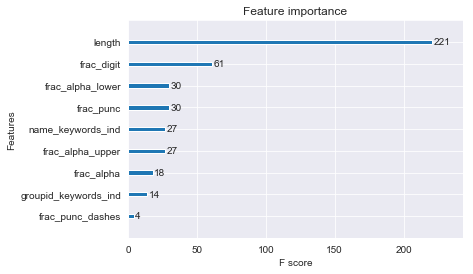

In [158]:
plot_importance(gb_clf);

Combine actuals with predictions.

In [159]:
# combine actual with predicted
y_test_combined = y_test.rename(index=str, columns={"y": "y_true"}).assign(y_pred=y_pred).assign(simulated=X_test_simulated['simulated'].values.astype(int))

y_test_combined = y_test_combined.assign(got_right=(y_test_combined.y_true == y_test_combined.y_pred).astype(int))

y_test_combined = y_test_combined.assign(y_pred_prob_0=y_pred_prob[:,0])
y_test_combined = y_test_combined.assign(y_pred_prob_1=y_pred_prob[:,1])
#y_test_combined = y_test_combined.assign(y_pred_prob_2=y_pred_prob[:,2])


In [160]:
from insurance_card_prediction import plot_confusion_matrix

Plot the confusion matrix.

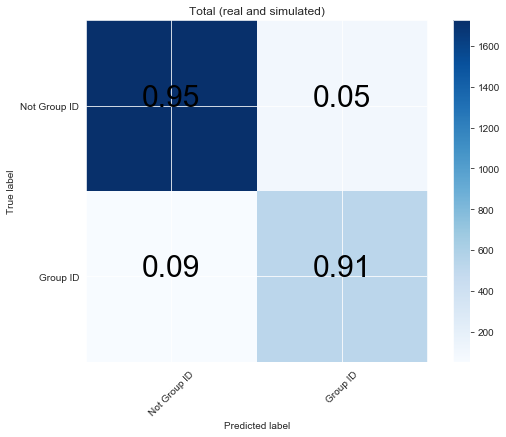

[[1724   96]
 [  54  527]]


In [161]:
cm = confusion_matrix(y_test_combined.y_true.values, y_test_combined.y_pred.values)

# plot it
plot_confusion_matrix(cm,
                      target_names=['Not Group ID','Group ID'],
                      title='Total (real and simulated)',
                      cmap=None,
                      normalize=True)

print(cm)

Split into real and simulated.

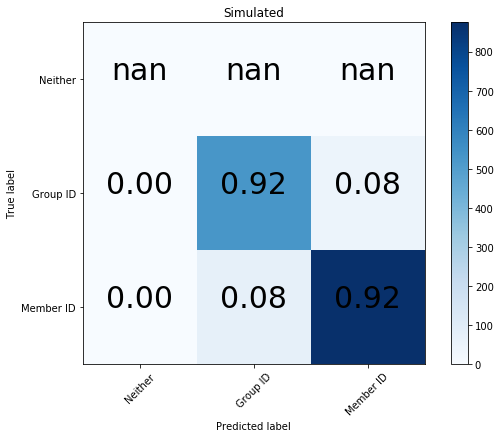

[[  0   0   0]
 [  0 527  46]
 [  1  73 875]]


In [73]:
# cm1 is simulated
cm1 = confusion_matrix(y_test_combined.loc[y_test_combined.simulated.values==1].y_true.values,  y_test_combined.loc[y_test_combined.simulated.values==1].y_pred.values)

if cm1.shape == (2,2):
    newrow = np.array([[0,0]])
    cm1 = np.vstack((newrow, cm1))

    newcol = np.array([[0],[0],[0]])
    cm1 = np.hstack((newcol, cm1))

# plot it
plot_confusion_matrix(cm1,
                      target_names=['Neither','Group ID', 'Member ID'],
                      title='Simulated',
                      cmap=None,
                      normalize=True)

print(cm1)

Now look at reals.

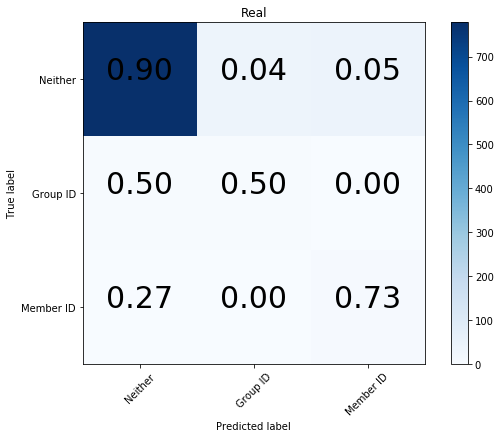

[[778  37  45]
 [  4   4   0]
 [  3   0   8]]


In [74]:
# cm2 is real
cm2 = confusion_matrix(y_test_combined.loc[y_test_combined.simulated.values==0].y_true.values,  y_test_combined.loc[y_test_combined.simulated.values==0].y_pred.values)

#newrow = np.array([[0,0]])
#cm1 = np.vstack((newrow, cm1))

#newcol = np.array([[0],[0],[0]])
#cm1 = np.hstack((newcol, cm1))

# plot it
plot_confusion_matrix(cm2,
                      target_names=['Neither','Group ID', 'Member ID'],
                      title='Real',
                      cmap=None,
                      normalize=True)

print(cm2)

In [128]:
a = y_test_combined.loc[y_test_combined.simulated==0]
a = y_test_combined.loc[y_test_combined.y_true==0]
a = a.loc[a.y_pred!=0]
a.loc[:,['y_true','y_pred']]

,y_true,y_pred
30374-0800,0,2
43,0,2
35,0,2
WASHINGTON,0,1
20,0,2
87726,0,2
05000,0,2
100000001,0,2
610011,0,1
CHILDI,0,1


In [79]:
y_test_combined.loc[y_test_combined.y_true!=0].head(10)

,y_true,y_pred,simulated,got_right,y_pred_prob_0,y_pred_prob_1,y_pred_prob_2
PHOAUWTIK,2,2,1,1,0.099076,0.096246,0.804678
987057200179,1,1,1,1,0.016479,0.885554,0.097966
87019363638,2,2,1,1,0.011182,0.065865,0.922952
891100251,2,2,1,1,0.005606,0.019466,0.974928
763537830378,1,1,1,1,0.016479,0.885554,0.097966
966337739-12,2,2,1,1,0.016701,0.052785,0.930514
08889719,1,1,1,1,0.037798,0.690810,0.271392
K8535,2,1,1,0,0.051245,0.678274,0.270481
53755132,1,1,1,1,0.037798,0.690810,0.271392
377869079-31,2,2,1,1,0.016701,0.052785,0.930514


In [107]:
low_prob_mask = y_test_combined.iloc[:,4:7].max(axis=1) < 0.57
y_test_combined.loc[low_prob_mask][115:126]

,y_true,y_pred,simulated,got_right,y_pred_prob_0,y_pred_prob_1,y_pred_prob_2
39250,2,2,1,1,0.049223,0.381607,0.569170
10527,2,2,1,1,0.049223,0.381607,0.569170
00577,1,2,1,0,0.049223,0.381607,0.569170
26709,2,2,1,1,0.049223,0.381607,0.569170
92161,2,2,1,1,0.049223,0.381607,0.569170
57854,1,2,1,0,0.049223,0.381607,0.569170
93095,1,2,1,0,0.049223,0.381607,0.569170
08328,2,2,1,1,0.049223,0.381607,0.569170
85563,1,2,1,0,0.049223,0.381607,0.569170
7952304120,0,2,0,0,0.410342,0.130900,0.458758


Text(0, 0.5, 'Frequency')

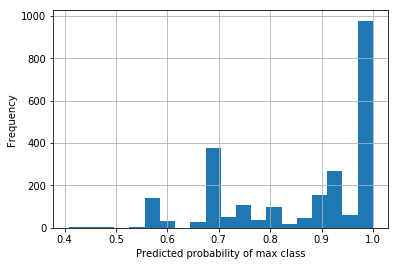

In [116]:
y_test_combined.iloc[:,4:7].max(axis=1).hist(bins=20);
plt.xlabel('Predicted probability of max class')
plt.ylabel('Frequency')

In [117]:
import seaborn as sns

Text(0, 0.5, 'Frequency in percentages')

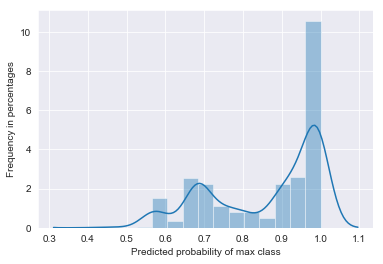

In [124]:
sns.set_style('darkgrid')
sns.distplot(y_test_combined.iloc[:,4:7].max(axis=1), norm_hist=False);
plt.xlabel('Predicted probability of max class')
plt.ylabel('Frequency in percentages')

In [ ]:
sns.set_style('darkgrid')

### Random Forest
Used for Group IDs classification.

In [165]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=102)
forest_clf.fit(X_train, y_train.y.values)

y_pred = forest_clf.predict(X_test)
print("%d out of %d exmaples were wrong."
      % ((y_test.y != y_pred).sum(), X_test.shape[0]))

187 out of 2401 exmaples were wrong.


Confusion matrix

In [166]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test.y.values, y_pred)
print("Confusion matrix: \n",cm, "\n")

tn, fp, fn, tp = cm.ravel()
print(' TN:',tn, '\n FP:',fp, '\n FN:',fn, '\n TP',tp)

Confusion matrix: 
 [[1344   97]
 [  90  870]] 

 TN: 1344 
 FP: 97 
 FN: 90 
 TP 870


Plot the confusion matrix

In [253]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j],2),
                     horizontalalignment="center",
                     color="black" if cm[i, j] > thresh else "black", fontsize=30)
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize=30)


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

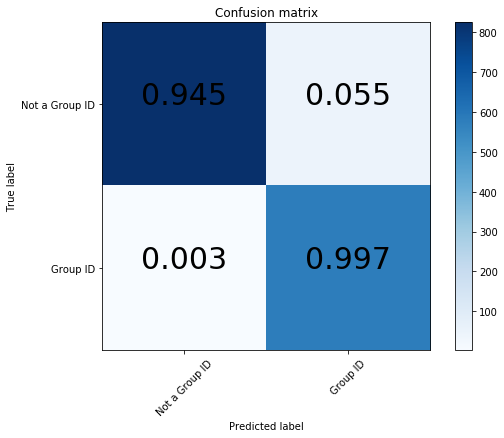

[[825  48]
 [  2 580]]


In [104]:
# plot it
plot_confusion_matrix(cm,
                      target_names=['Not a Group ID','Group ID'],
                      title='Confusion matrix',
                      cmap=None,
                      normalize=True)

print(cm)

In [105]:
# combine actual with predicted
y_test_combined = y_test.rename(index=str, columns={"y": "y_true"}).assign(y_pred=y_pred).assign(simulated=X_test_simulated['simulated_1'].values.astype(int))
#y_test_combined = y_test_combined.assign(simulated_0=X_test_simulated['simulated_1'].values)
y_test_combined = y_test_combined.assign(got_right=(y_test_combined.y_true == y_test_combined.y_pred).astype(int))

y_test_combined.head()

,y_true,y_pred,simulated,got_right
INSURANCE,0,0,0,1
John,0,0,0,1
967462-020-14860,1,1,1,1
AT,0,0,0,1
636498,1,1,1,1


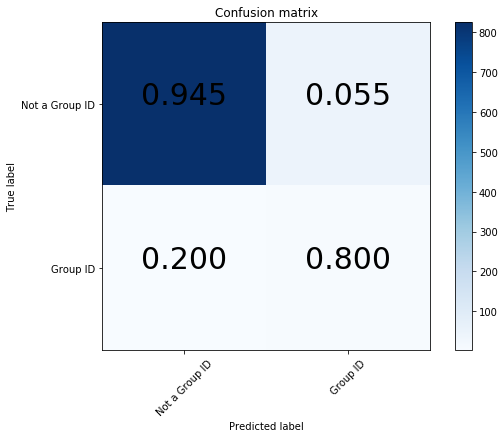

Real data
Confusion matrix: 
 [[825  48]
 [  2   8]] 



In [106]:
mask = (y_test_combined.simulated==0)# & (y_test_combined.y_true==0)

cm2 = confusion_matrix(y_test_combined[mask].y_true.values, y_test_combined[mask].y_pred.values)

if cm2.shape == (1,1):
    cm2 = np.array([[0,0],[0,cm2[0,0]]])


plot_confusion_matrix(cm2,
                      target_names=['Not a Group ID','Group ID'],
                      title='Confusion matrix',
                      cmap=None,
                      normalize=True);

print('Real data')
print("Confusion matrix: \n",cm2, "\n")


Find the area under the curve.

In [107]:
"""from sklearn.metrics import roc_auc_score

y_scores = forest_clf.predict_proba(X)
print('AUC:', round(roc_auc_score(y, y_scores[:,1]),3))"""

"from sklearn.metrics import roc_auc_score\n\ny_scores = forest_clf.predict_proba(X)\nprint('AUC:', round(roc_auc_score(y, y_scores[:,1]),3))"

Find feature importances

In [108]:
"""# feature importance
df_fi = pd.DataFrame(index = df.columns.tolist()[3:])
df_fi = df_fi.assign(importance=forest_clf.feature_importances_)
df_fi = df_fi.sort_values(by=['importance'], ascending=False)"""

"# feature importance\ndf_fi = pd.DataFrame(index = df.columns.tolist()[3:])\ndf_fi = df_fi.assign(importance=forest_clf.feature_importances_)\ndf_fi = df_fi.sort_values(by=['importance'], ascending=False)"

Plot feature importances

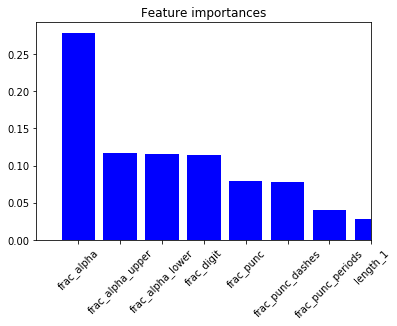

In [109]:
# Plot feature importances
cols = X_train.columns.values
importances = forest_clf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="b", align="center")
plt.xticks(range(X_train.shape[1]), cols)
plt.xlim([-1, X.shape[1]])
plt.xticks(rotation=45)
plt.show();

#### Plot decision boundaries

https://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_decision_regions.html

Automatically created module for IPython interactive environment


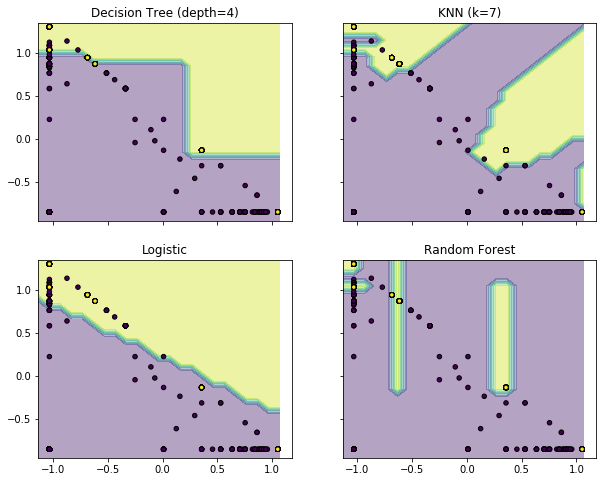

In [144]:
print(__doc__)

from itertools import product

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Loading some example data
iris = datasets.load_iris()
X = X_train.loc[:,['frac_alpha','frac_digit']].values
y = y_train.y.values
#X = iris.data[:, [0, 2]]
#y = iris.target

# Training classifiers
clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=7)
clf3 = LogisticRegression()
#clf3 = SVC(gamma=.1, kernel='rbf', probability=True)
eclf = RandomForestClassifier(random_state=102)
#eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2),
#                                    ('svc', clf3)],
#                        voting='soft', weights=[2, 1, 2])

clf1.fit(X, y)
clf2.fit(X, y)
clf3.fit(X, y)
eclf.fit(X, y)

# Plotting decision regions
x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        [clf1, clf2, clf3, eclf],
                        ['Decision Tree (depth=4)', 'KNN (k=7)',
                         'Logistic', 'Random Forest']):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], c=y,
                                  s=20, edgecolor='k')
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

In [40]:
# AUC
from sklearn.metrics import roc_auc_score

y_test_scores = forest_clf.predict_proba(X_test)
print('AUC:', round(roc_auc_score(y_test, y_test_scores[:,1]),3))

AUC: 0.988


Train model on simulated data and test on real data.

In [135]:
# put all real group ids in test set.
np.random.seed(103)
ind_test = np.where(np.logical_and(df3.simulated_1==0, df3.y==1))[0]
sample = [i for i in range(df3.shape[0]) if i not in ind_test]
more_indices = np.random.choice(sample, int(len(ind_test)*20), replace=False)
more_indices1 = [i for i in more_indices if df3.simulated_1[i]==0]  # throw away if it's simulated
ind_test = np.concatenate((ind_test, more_indices1))

ind_train = np.array([i for i in range(df3.shape[0]) if i not in ind_test])

X_train = df3.iloc[ind_train,:-1].copy()
X_test = df3.iloc[ind_test,:-1].copy()

y_train = df3.iloc[ind_train,-1].copy()
y_test = df3.iloc[ind_test,-1].copy()

X_train_simulated = pd.DataFrame(X_train['simulated_1'].copy())
X_test_simulated = pd.DataFrame(X_test['simulated_1'].copy())

X_train.drop(columns=['simulated_0', 'simulated_1'], inplace=True)
X_test.drop(columns=['simulated_0', 'simulated_1'], inplace=True)

y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

In [136]:
forest_clf1 = RandomForestClassifier(random_state=102)
forest_clf1.fit(X_train, y_train.y.values)

y_pred = forest_clf1.predict(X_test)
print("%d out of %d exmaples were wrong."
      % ((y_test.y != y_pred).sum(), X_test.shape[0]))

15 out of 287 exmaples were wrong.


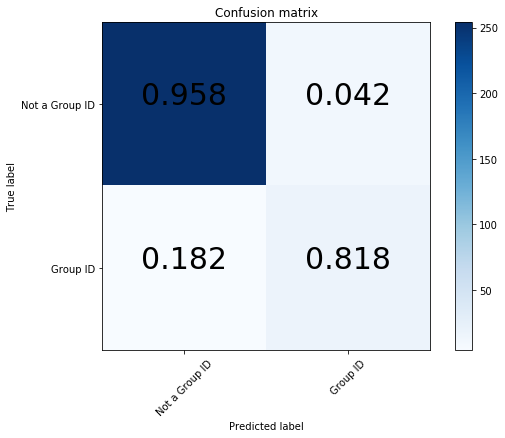

Test set has all the real group IDs
Confusion matrix: 
 [[254  11]
 [  4  18]] 



In [137]:
cm3 = confusion_matrix(y_test.y.values, y_pred)

if cm3.shape == (1,1):
    cm3 = np.array([[0,0],[0,cm2[0,0]]])


plot_confusion_matrix(cm3,
                      target_names=['Not a Group ID','Group ID'],
                      title='Confusion matrix',
                      cmap=None,
                      normalize=True);

print('Test set has all the real group IDs')
print("Confusion matrix: \n",cm3, "\n")